In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append("../src")
sys.path.append("../src/models")
sys.path.append("../src/visualization")
import LDA
import PCA
import kNN
import utils
from k_means__MSD__corrMat import *
from viz_kMeans_MDS_corrMat import *
import LMs as lms
import dendrogram as dend

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_feather('../data/processed/warehouse.f')
ds = utils.standardize(df,['num_fault','num_iss','sev_iss','type_iss_bug','type_iss_vulnerability','type_iss_codeSmell'])
train, test = utils.TrainTest(df)
strain, stest = utils.TrainTest(ds)

# LDA

In [25]:
features = ['line_add', 'line_rem', 'mes_len', 'elap_time', 'mes_gra', 'jira_time']
target = ['sev_iss']

acc, coef = LDA.LinDisAnalysis(train, test, features, target)
r = LDA.interpreteCoef(features,coef)
r[0][:5], " ",r[1][:5], " ",r[2][:5], " ",r[3][:5], " ",r[4][:5], " ",r[5][:5], " ", acc

([('mes_gra', 0.001215533430498023),
  ('line_add', -0.0004999672383693845),
  ('mes_len', -0.00020979146174094306),
  ('jira_time', 0.00011102121820159039),
  ('elap_time', 3.204350080348958e-05)],
 ' ',
 [('mes_gra', -0.01912628942671625),
  ('elap_time', -0.0012425729267101027),
  ('mes_len', 0.0008933675442483757),
  ('jira_time', -0.0007812569664049369),
  ('line_rem', 0.0001865722977216818)],
 ' ',
 [('mes_gra', 0.008942204126507544),
  ('line_add', 0.004105898452685585),
  ('mes_len', 0.0011989367908417214),
  ('jira_time', -0.0007344150381293497),
  ('elap_time', -0.00013208674108202887)],
 ' ',
 [('mes_gra', -0.029734862003423092),
  ('line_add', 0.0029678410630781084),
  ('mes_len', 0.0017780325842378477),
  ('jira_time', -0.0007795367221943546),
  ('line_rem', -0.00025220730917371403)],
 ' ',
 [('mes_gra', -0.05013225929470821),
  ('mes_len', 0.0022263722850494037),
  ('line_add', 0.0008524472374621912),
  ('jira_time', -0.0008251769886075928),
  ('line_rem', -0.000474288462

# PCA

In [26]:
features = ['jira_time','num_fault','num_iss','sev_iss','type_iss_bug','type_iss_vulnerability','type_iss_codeSmell']

target = 'proj_id'

PCA.all(df,features, target)

<AxesSubplot:title={'center':'2 component PCA'}, xlabel='Principal Component 1', ylabel='Principal Component 2'>

# KNN

In [27]:
features = ['line_add','line_rem','mes_len','elap_time','mes_gra','jira_time']

for i in range(1,30):
    features.append('rt_'+"{:02d}".format(i))

    
targets = ['num_fault','num_iss','sev_iss','type_iss_bug','type_iss_vulnerability','type_iss_codeSmell']
for target in targets:
    k = kNN.KNN(strain, stest, features, np.array([target]).ravel())
    print(target,': ',k[1])

num_fault :  0.005809865669984828
num_iss :  289.3644673056285
sev_iss :  20234.48850978796
type_iss_bug :  0.5762128557155016
type_iss_vulnerability :  1.7202013099951894
type_iss_codeSmell :  264.6294267845909


# Correlation Matrix

In [3]:
df_mds = pd.read_feather('../data/processed/StandardizedWarehouse.f')

In [4]:
plot_corr_matrix(df_mds)

In [5]:
df_proj = df_mds.groupby(by="proj_id").sum()
plot_corr_matrix(df_proj)

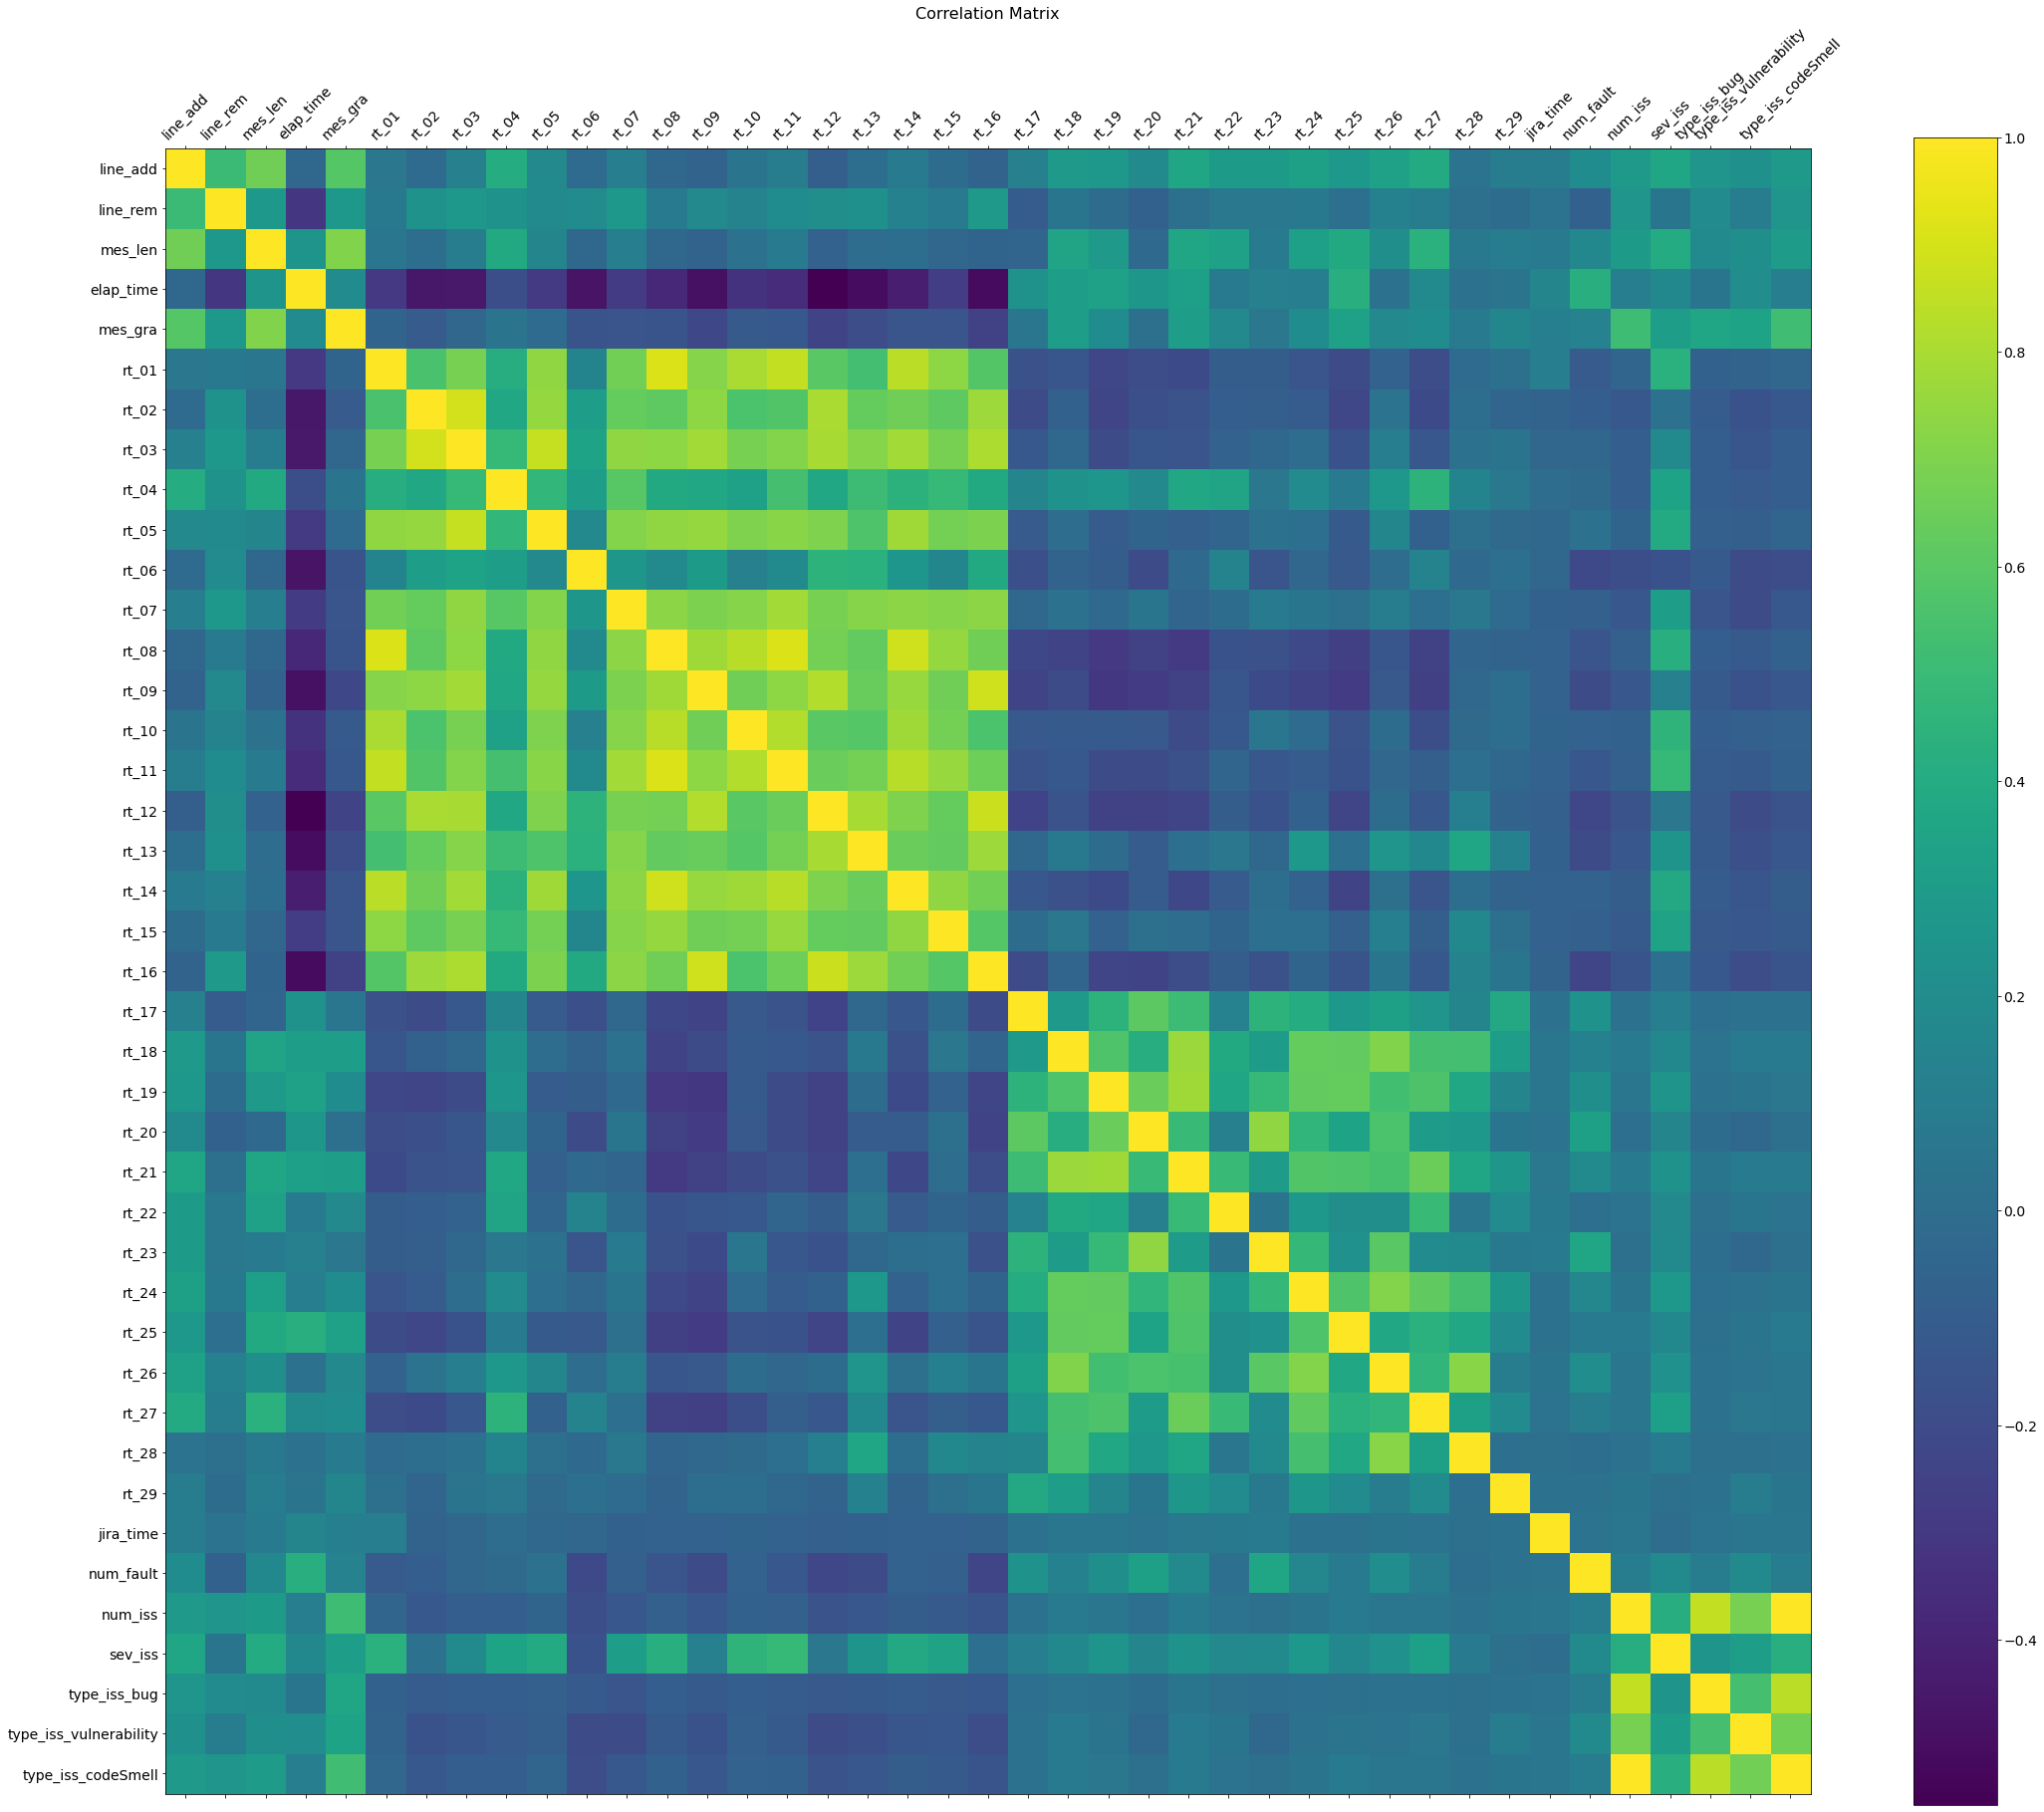

In [6]:
df_auth = df_mds.groupby(by="auth_id").sum()
plot_corr_matrix(df_auth)

# Multidimensional Scaling (MDS)

In [7]:
df_sample_commit = df_mds.sample(frac=0.01, replace=False, random_state=41)  # increase sample size only if you have enough memory resources
df_sample_proj = df_proj.sample(frac=1, replace=False, random_state=41)
df_sample_auth = df_auth.sample(frac=1, replace=False, random_state=41)

In [8]:
df_mds_commit = df_sample_commit.select_dtypes(exclude=['object']).iloc[:,:-6]
df_mds_proj = df_sample_proj.select_dtypes(exclude=['object']).iloc[:,:-6]
df_mds_auth = df_sample_auth.select_dtypes(exclude=['object']).iloc[:,:-6]

In [9]:
mds = MultiDimScaling(max_iter=30, n_init=2, random_state=0, n_jobs=2)
X_transform_commit = mds.fit_transform(df_mds_commit)
X_transform_proj = mds.fit_transform(df_mds_proj)
X_transform_auth = mds.fit_transform(df_mds_auth)

In [10]:
plot_MDS(X_transform_proj, df_sample_proj, "num_iss")

In [11]:
plot_MDS(X_transform_proj, df_sample_proj, "num_fault")

# K-means

For n_clusters = 2 The average silhouette_score is : 0.744430514042793
For n_clusters = 4 The average silhouette_score is : 0.43740160723344446
For n_clusters = 8 The average silhouette_score is : 0.3811574112964002
For n_clusters = 12 The average silhouette_score is : 0.1446862483871414


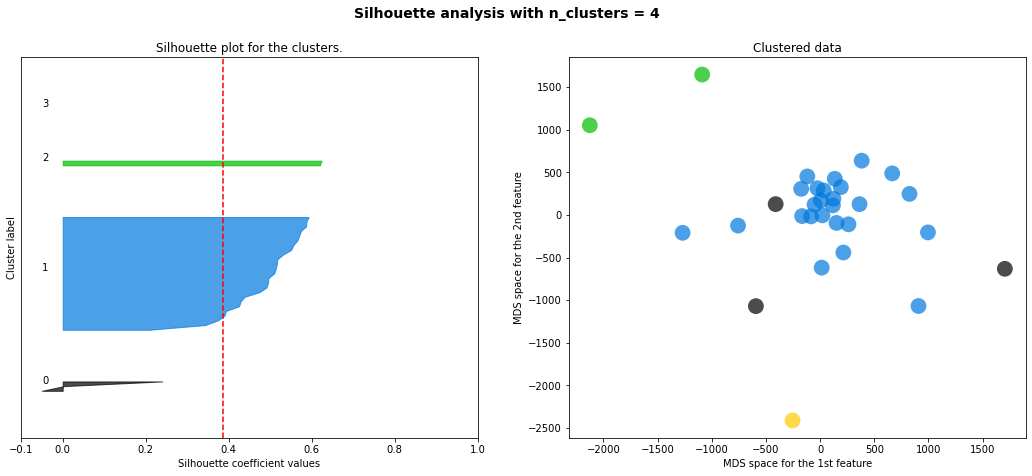

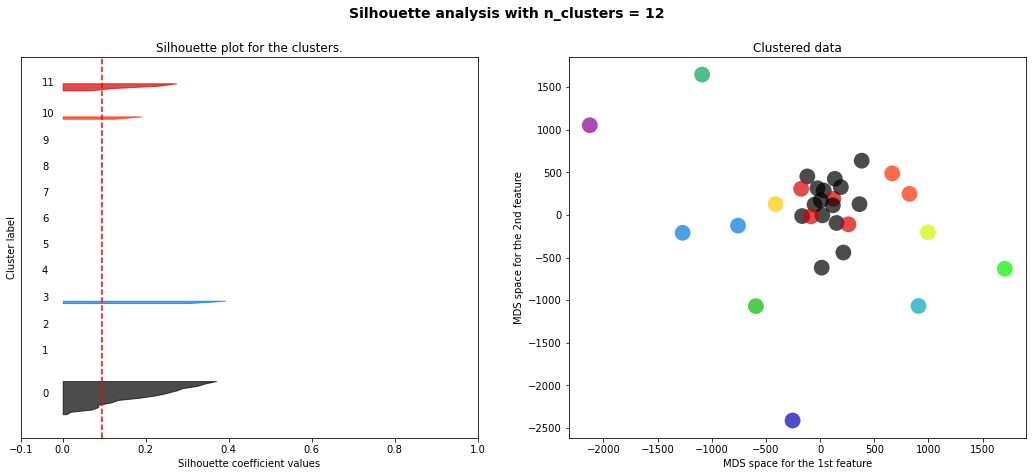

In [12]:
choose_n_clusters(df=df_sample_proj, X_transform=X_transform_proj, range_n_clusters=[2, 4, 8, 12])

# Dendrogram

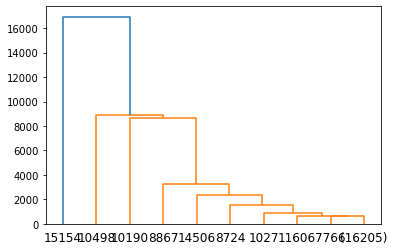

In [13]:
# The dendrogram is more permissive than MDS but also has high memory requirements
df_sample_commit = df.sample(frac=0.2, replace=False, random_state=2021)
dend.dendogram(df_sample_commit.iloc[:,2:37]) # Only use the features

In [14]:
# Do the same now grouping by projects (no need to sample now)
df_proj = df.groupby(by="proj_id").sum()
dend.dendogram(df_proj.iloc[:,2:37]) # Only use the features

# LM

In [15]:
# Create a copy of the dataset (to keep compatibiltity with other procedures) and add the has_iss variable
df_lm = df.copy()
df_lm["has_iss"] = df_lm["num_iss"]
df_lm.loc[df_lm.num_iss > 0, "has_iss"] = 1

In [16]:
# Split the dataset by columns: features and targets
feat = df_lm.iloc[:,2:37] # All columns from [line_add to jira_time]
tars = df_lm['num_iss']  # A test with the num_iss variable

In [17]:
# lm_coeffs fits a linear model and returns the value of the coefficients
# large values indicate a strong linear relationship for this variable (either posstive or negative)
coeffs = lms.lm_coeffs(feat, tars)
pd.DataFrame({'Variable':list(feat.columns),'LM coefficient':coeffs})

Variable  LM coefficient
0    line_add        0.474055
1    line_rem       -0.024154
2     mes_len       -0.018505
3   elap_time        0.004785
4     mes_gra        0.818365
5       rt_01        0.102063
6       rt_02       -0.322113
7       rt_03        2.303391
8       rt_04       -1.094889
9       rt_05       -0.157168
10      rt_06        1.235635
11      rt_07        0.032165
12      rt_08        1.858515
13      rt_09       -0.057868
14      rt_10        0.708767
15      rt_11        0.761399
16      rt_12       -0.270791
17      rt_13        0.892726
18      rt_14        3.249790
19      rt_15       -0.038188
20      rt_16        0.678849
21      rt_17       -0.182038
22      rt_18       11.739346
23      rt_19       -0.780086
24      rt_20       -2.343679
25      rt_21       -0.797880
26      rt_22       -4.021255
27      rt_23       41.764168
28      rt_24      -11.664896
29      rt_25        8.157665
30      rt_26        2.874273
31      rt_27      -20.907538
32      rt_28      -44.457835
33      rt_29       -4.936191
34  jira_time       -0.005497

In [18]:
# Now do the same but with a train/test partition in order to later check the accuracy of the results
train_lm, test_lm = utils.TrainTest(df_lm)
tr_feat = train_lm.iloc[:,2:37]
tr_tars = train_lm['num_iss']
te_feat = test_lm.iloc[:,2:37]
te_tars = test_lm['num_iss']

In [19]:
# The fit_lm function returns the linear model object: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
lm = lms.fit_lm(tr_feat, tr_tars, intercept=True)

# The score method gives an indication of how good is the model. Ideally should be close to 1; close to 0 means it's very bad
print(lm.score(te_feat, te_tars))

0.02687409691176934


In [20]:
# Compute the score for each target variable to see if some work better than others
for i in range(37,44):
    tr_feat = train_lm.iloc[:,2:37]
    tr_tars = train_lm.iloc[:,i:i+1]
    te_feat = test_lm.iloc[:,2:37]
    te_tars = test_lm.iloc[:,i:i+1]
    lm = lms.fit_lm(tr_feat, tr_tars, intercept=True)
    print(f'Score for \'{list(df_lm.columns)[i]}\': {round(lm.score(te_feat, te_tars),2)}')

Score for 'num_fault': 0.0
Score for 'num_iss': 0.03
Score for 'sev_iss': 0.0
Score for 'type_iss_bug': 0.01
Score for 'type_iss_vulnerability': -0.0
Score for 'type_iss_codeSmell': 0.02
Score for 'has_iss': 0.0
